In [111]:
import os
import glob
from pathlib import Path
import ssl
import random
from datetime import datetime
import time
import gc
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skimage.util import random_noise

import torch
from torchvision import datasets, transforms
from torchvision.transforms import Resize
from torch.utils.data import Dataset
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.utils import make_grid
from torchvision.io import read_image, ImageReadMode
from torchsummary import summary

import torch.nn as nn
from torch import flatten


BATCH_SIZE = 16
SHUFFLE = True
NUM_WORKERS = 0
PIN_MEMORY = True


# if using remote server
current_path = os.path.basename(os.path.normpath(os.getcwd()))
DIR = "rt-denoiser"
if(current_path != DIR):
	os.chdir(DIR)
	print("Changed directory into: "+DIR)

# set up gpu
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if str(device) == "cuda:0":
	print(str(device)+" -> "+torch.cuda.get_device_name(0))
else:
	print(device)

cuda:0 -> NVIDIA GeForce RTX 3060 Ti


In [112]:
# image loader

img_shape = (3,128,128) # include normals

class PreAugmentDataset(Dataset):
	def __init__(self, train=False):
		
		shape = (0,3,128,128)
		self.original_images = np.empty(shape)
		self.images = np.empty(shape)
		self.normals = np.empty(shape)
		self.train = train

		self.dir = "./data/"
		self.listdir = sorted(Path(self.dir).iterdir(), key=os.path.getmtime) # sort by time for proper results
		self.count = len(self.listdir)

		train_test_split = 0.9
		if self.train:
			loop_start = 0
			loop_count = math.floor(self.count*train_test_split)
		else:
			loop_start = math.floor(self.count*train_test_split)
			loop_count = self.count

		for i in range(loop_start, loop_count):

			file = str(self.listdir[i])

			if("-N-" in file):
				file = open(file, "r")
				normal_str = file.readline()
				normal_clean = normal_str.split(",")
				normal_clean.pop(len(normal_clean)-1) # remove last one which is empty
				normal_arr = [[]]
				r = 0
				for i, normal_str in enumerate(normal_clean):
					str_list = normal_str.split(" ")
					if(len(str_list) <= 1):
						continue
					if(len(normal_arr[r]) == shape[2]):
						r += 1 # new row
						normal_arr.append([])
					normal_arr[r].append(list(map(float, str_list))) # convert to int and append
				normal_numpy = np.array(normal_arr)
				normal_numpy = np.moveaxis(normal_numpy, -1, 0)
				normal_numpy = np.expand_dims(normal_numpy, 0)
				self.normals = np.append(self.normals, normal_numpy, 0)
				file.close()
				continue

			# else it is an image
			image = read_image(file, ImageReadMode.RGB) # read as RGB, not RGBA
			image = np.expand_dims(image, 0) # match initial shape
			last_iteration_number = file[-5]

			if(int(last_iteration_number) % 2 != 0):
				self.images = np.append(self.images, image, 0)
			else:
				self.original_images = np.append(self.original_images, image, 0)
				

		transform = Resize((img_shape[1],img_shape[2]))

		self.images = torch.tensor(self.images / 255., dtype=torch.float32) # to tensor
		self.images = torch.clamp(self.images, 0., 1.) # clamp between 0 and 1
		self.images = transform(self.images)

		self.original_images = torch.tensor(self.original_images / 255., dtype=torch.float32) # to tensor
		self.original_images = torch.clamp(self.original_images, 0., 1.) # clamp between 0 and 1
		self.original_images = transform(self.original_images)

		self.normals = torch.tensor((self.normals+1)/2, dtype=torch.float32)
		self.normals = torch.clamp(self.normals, 0., 1.) # clamp between 0 and 1
		self.normals = transform(self.normals)
		
		print("-"*30)
		print("Images:",self.images.shape)
		print("Original Images:",self.original_images.shape)
		print("Normals:",self.normals.shape)
		print("-"*30)

	def applyTransforms(self):

		# salt and pepper noise
		level_of_noise = 0.5
		self.images = self.images + torch.randn(self.images.size()) * level_of_noise
		
		self.images = torch.clamp(self.images, 0., 1.).type(torch.float32)

	def __len__(self):
		return len(self.images)

	def __getitem__(self, idx):
		image = self.images[idx]
		original_image = self.original_images[idx]
		normals = self.normals[idx]
		return image, normals, original_image
		

train_ds = PreAugmentDataset(train=True)
val_ds = PreAugmentDataset(train=False)

train_loader = torch.utils.data.DataLoader(
	train_ds, 
	batch_size = BATCH_SIZE, 
	shuffle = SHUFFLE, 
	num_workers=NUM_WORKERS, 
	pin_memory=PIN_MEMORY
)
val_loader = torch.utils.data.DataLoader(
	val_ds, 
	batch_size = BATCH_SIZE, 
	shuffle = SHUFFLE,
	num_workers=NUM_WORKERS,
	pin_memory=PIN_MEMORY
)

print('Training set has {} instances'.format(len(train_ds)))
print('Validation set has {} instances'.format(len(val_ds)))

------------------------------
Images: torch.Size([450, 3, 128, 128])
Original Images: torch.Size([450, 3, 128, 128])
Normals: torch.Size([450, 3, 128, 128])
------------------------------
------------------------------
Images: torch.Size([50, 3, 128, 128])
Original Images: torch.Size([50, 3, 128, 128])
Normals: torch.Size([50, 3, 128, 128])
------------------------------
Training set has 450 instances
Validation set has 50 instances


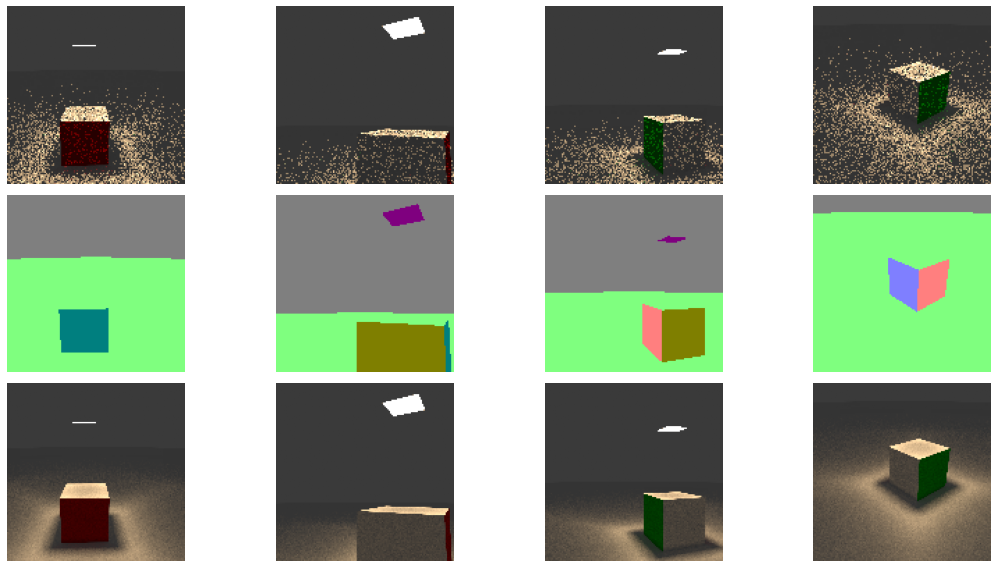

In [113]:
# plot images
fig, axes = plt.subplots(3,4, figsize=(16, 8))

train_loader_iter = iter(train_loader)
batch = next(train_loader_iter)

for i, ax in enumerate(axes.flat):
	if(i < 4):
		# input images
		image = batch[0][i%4]
	elif (i >= 4 and i < 8):
		# original images
		image = batch[1][i%4]
	else:
		image = batch[2][i%4]
	image = image.squeeze(0) # (s, c, w, h) -> (c, w, h)
	image = torch.movedim(image, 0, -1) # (c, w, h) -> (w, h, c)
	ax.imshow(image)
	ax.axis("off")

plt.tight_layout()
plt.show()

In [114]:
# create model
class ClassifierModel(nn.Module):
	def __init__(self, shape):
		super(ClassifierModel, self).__init__()
		
		self.shape = shape
		self.dropout = nn.Dropout(0.25)
		self.act_fn = nn.ReLU(True)

		#--- Encoder
		self.conv0 = nn.Conv2d(in_channels=6, out_channels=32, kernel_size=3, padding="same")
		self.bnorm0 = nn.BatchNorm2d(num_features=32)
		self.conv1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same")
		self.bnorm1 = nn.BatchNorm2d(num_features=64)
		
		self.pool1 = nn.MaxPool2d(4, return_indices=True)
		self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same")
		self.bnorm2 = nn.BatchNorm2d(num_features=128)
		self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding="same")
		self.bnorm3 = nn.BatchNorm2d(num_features=256)
		
		self.pool2 = nn.MaxPool2d(2, return_indices=True)
		self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding="same")
		self.bnorm4 = nn.BatchNorm2d(num_features=256)
		self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding="same")
		#self.bnorm5 = nn.BatchNorm2d(num_features=512)

		# #--- Flatten
		# self.flatten = nn.Flatten(start_dim=1)

		# #--- Fully Connected
		# self.fc_dim_io = 512
		# self.fc_dim = 2048
		# self.fc_io = 131072
		# self.fc = nn.Sequential(
		# 	nn.Sigmoid(),
		# 	nn.Linear(self.fc_io, self.fc_dim_io),
		# 	self.act_fn,
		# 	#self.dropout,
		# 	nn.Linear(self.fc_dim_io, self.fc_dim),
		# 	self.act_fn,
		# 	self.dropout,
		# 	nn.Linear(self.fc_dim, self.fc_dim_io),
		# 	self.act_fn,
		# 	self.dropout,
		# 	nn.Linear(self.fc_dim_io, self.fc_io),
		# 	self.act_fn,
		# 	#self.dropout,
		# )

		# #-- Unflatten

		#--- Decoder
		
		self.unconv5 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, padding=1)
		self.unconv4 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
		self.unpool2 = nn.MaxUnpool2d(2)

		self.unconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
		self.unconv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
		self.unpool1 = nn.MaxUnpool2d(4)

		self.unconv1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
		self.unconv0 = nn.ConvTranspose2d(in_channels=32, out_channels=self.shape[0], kernel_size=3, padding=1)

		#-- Output Block
		self.tan = nn.Tanh()
		

	def forward(self, img, norm):

		#--- Prepare
		#print("Initial size:",x.size())
		img = self.tan(img)

		x = torch.concat((img, norm), 1)

		#--- Encode
		x = self.bnorm0(self.conv0(x))
		x = self.dropout(x)
		x = self.act_fn(self.bnorm1(self.conv1(x)))
		x = self.dropout(x)
		
		x, indices1 = self.pool1(x)
		x = self.act_fn(self.bnorm2(self.conv2(x)))
		x = self.dropout(x)
		x = self.act_fn(self.bnorm3(self.conv3(x)))
		x = self.dropout(x)
		
		x, indices2 = self.pool2(x)
		x = self.act_fn(self.bnorm4(self.conv4(x)))
		x = self.dropout(x)
		x = self.act_fn(self.conv5(x))
		x = self.dropout(x)

		# #--- Flatten
		# last_size = x.size()
		# x = self.flatten(x)
		# #--- Fully Connected
		# x = self.fc(x)
		# #--- Unflatten
		# x = nn.Unflatten(dim=1, unflattened_size=(last_size[1], last_size[2], last_size[3]))(x)

		#--- Decode
		x = self.act_fn(self.unconv5(x))
		x = self.dropout(x)
		x = self.act_fn(self.unconv4(x))
		x = self.dropout(x)
		x = self.unpool2(x, indices2)

		x = self.act_fn(self.unconv3(x))
		x = self.dropout(x)
		x = self.act_fn(self.unconv2(x))
		x = self.dropout(x)
		x = self.unpool1(x, indices1)
		
		x = self.act_fn(self.unconv1(x))
		x = self.dropout(x)
		x = self.unconv0(x)

		#--- Output
		x = x.view(-1, self.shape[0], self.shape[1], self.shape[2]) # format back to original shape

		output = self.tan(x)
		return output

	def training_step(self, batch):
		images = batch[0].to(device, non_blocking=True)
		normals = batch[1].to(device, non_blocking=True)
		original_images = batch[2].to(device, non_blocking=True)
		self.optimizer.zero_grad()
		out = self(images, normals)
		loss = self.criterion(out, original_images)
		loss.backward()
		self.optimizer.step()
	
	def validation_step(self, batch):
		images = batch[0].to(device, non_blocking=True)
		normals = batch[1].to(device, non_blocking=True)
		original_images = batch[2].to(device, non_blocking=True)
		out = self(images, normals)
		loss = self.criterion(out, original_images)
		return {'val_loss': loss}
		
	def validation_epoch_end(self, outputs):
		batch_losses = [x['val_loss'] for x in outputs]
		epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
		return {'val_loss': epoch_loss.item()}
	
	def epoch_end(self, epoch, result, ttime=0, vtime=0):
		print("Epoch [{}]: train time: {:.1f}s, val time: {:.1f}s, val_loss: {:.3f}".format(epoch+1, ttime, vtime, result['val_loss']*100))

In [115]:
def evaluate(model, val_loader):
	outputs = [model.validation_step(batch) for batch in val_loader]
	return model.validation_epoch_end(outputs)

def fit(epochs, model, train_loader, val_loader, optimizer=torch.optim.Adam, lr=0.0001, valid=True, counter=0):
	history = []
	print("Learning rate:",lr)
	model.optimizer = optimizer(model.parameters(), lr)
	for epoch in range(epochs):
		t0 = time.time()

		# Training Phase 
		model.train()
		for b, batch in enumerate(train_loader):
			model.training_step(batch)
			
			# if b % 10 == 0:
			# 	print(f'{b}/{len(train_loader)}', end="\r")
				
		t1 = time.time()

		# Validation phase
		if valid:
			with torch.no_grad():
				model.eval()
				result = evaluate(model, val_loader)
				model.epoch_end(epoch+counter, result, (t1 - t0), (time.time() - t1))
				history.append(result)
	return history

In [116]:
# build model and test evaluate

# clear cache
# torch.cuda.synchronize()
# torch.cuda.empty_cache()
# gc.collect()

# Model (on GPU)
model = ClassifierModel(img_shape)

model.to(device, non_blocking=True)
model.optimizer = torch.optim.Adam(model.parameters(), 0.0001) # lr
model.criterion = nn.MSELoss()

summary(model, [img_shape, img_shape]) # image and normals

# test validation dataset
history = []
history = [evaluate(model, val_loader)]
history

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              Tanh-1          [-1, 3, 128, 128]               0
            Conv2d-2         [-1, 32, 128, 128]           1,760
       BatchNorm2d-3         [-1, 32, 128, 128]              64
           Dropout-4         [-1, 32, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          18,496
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
           Dropout-8         [-1, 64, 128, 128]               0
         MaxPool2d-9  [[-1, 64, 32, 32], [-1, 64, 32, 32]]               0
           Conv2d-10          [-1, 128, 32, 32]          73,856
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
          Dropout-13          [-1, 128, 32, 32]               0
           Conv2d-14        

[{'val_loss': 0.17583757638931274}]

In [123]:
history += fit(5000, model, train_loader, val_loader, lr=0.0001, counter=len(history))

Learning rate: 0.0001
Epoch [203]: train time: 1.1s, val time: 0.2s, val_loss: 0.249
Epoch [204]: train time: 0.8s, val time: 0.2s, val_loss: 0.286
Epoch [205]: train time: 0.8s, val time: 0.2s, val_loss: 0.258
Epoch [206]: train time: 0.8s, val time: 0.2s, val_loss: 0.281
Epoch [207]: train time: 0.8s, val time: 0.2s, val_loss: 0.310
Epoch [208]: train time: 0.8s, val time: 0.2s, val_loss: 0.262
Epoch [209]: train time: 0.8s, val time: 0.2s, val_loss: 0.242
Epoch [210]: train time: 0.8s, val time: 0.2s, val_loss: 0.310
Epoch [211]: train time: 0.8s, val time: 0.2s, val_loss: 0.273
Epoch [212]: train time: 0.8s, val time: 0.2s, val_loss: 0.228
Epoch [213]: train time: 0.8s, val time: 0.2s, val_loss: 0.264
Epoch [214]: train time: 0.8s, val time: 0.2s, val_loss: 0.282
Epoch [215]: train time: 0.8s, val time: 0.2s, val_loss: 0.324
Epoch [216]: train time: 0.8s, val time: 0.2s, val_loss: 0.241
Epoch [217]: train time: 0.8s, val time: 0.2s, val_loss: 0.259
Epoch [218]: train time: 0.8s, va

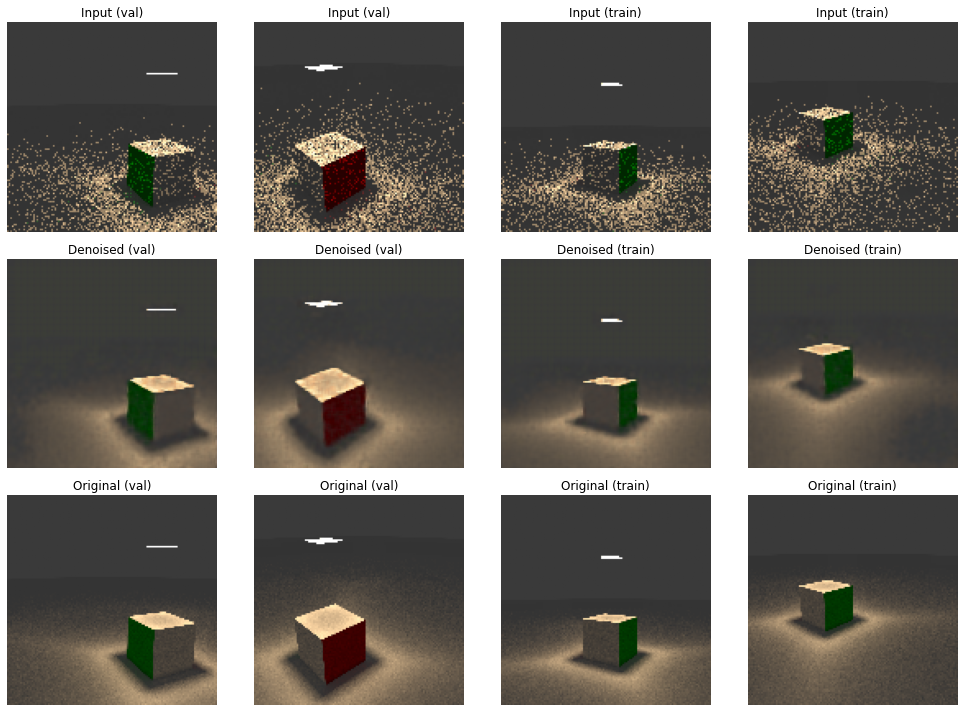

In [126]:
# plot images
fig, axes = plt.subplots(3,4, figsize=(14, 10))

model.eval()
with torch.no_grad():
	# get data
	train_batch = next(iter(train_loader))
	train_images = train_batch[0][0:4].to(device)
	train_normals = train_batch[1][0:4].to(device)
	train_original_images = train_batch[2][0:4].to(device)

	val_batch = next(iter(val_loader))
	val_images = val_batch[0][0:4].to(device)
	val_normals = val_batch[1][0:4].to(device)
	val_original_images = val_batch[2][0:4].to(device)

	# denoise
	train_denoised_images = (model(train_images, train_normals)).cpu()
	val_denoised_images = (model(val_images, val_normals)).cpu()
	
	val_original_images = val_original_images.cpu()
	train_original_images = train_original_images.cpu()
	val_images = val_images.cpu()
	train_images = train_images.cpu()

	for i, ax in enumerate(axes.flat):
		if(i < 4):
			if i < 2:
				ax.set_title("Input (val)")
				image = val_images[i%4]
			else:
				ax.set_title("Input (train)")
				image = train_images[i%4]
		elif(i >= 4 and i < 8):
			if i < 6:
				ax.set_title("Denoised (val)")
				image = val_denoised_images[i%4]
			else:
				ax.set_title("Denoised (train)")
				image = train_denoised_images[i%4]
		elif(i >= 8 and i < 12):
			if i < 10:
				ax.set_title("Original (val)")
				image = val_original_images[i%4]
			else:
				ax.set_title("Original (train)")
				image = train_original_images[i%4]

		image = torch.movedim(image, 0, -1)
		ax.imshow(image.clamp(0,1).squeeze())
		#ax.set_title(labels[i%4].item())
		ax.axis("off")

	plt.tight_layout()
	plt.show()

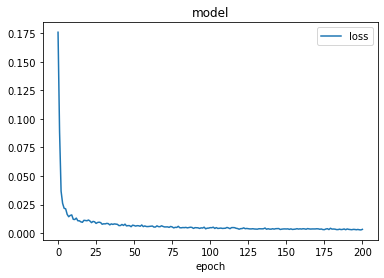

In [119]:
# format epoch data then graph
f_history = {"val_loss": [], "val_acc": []}
for epoch in history:
	f_history['val_loss'].append(epoch['val_loss'])
	#f_history['val_acc'].append(epoch['val_acc'])

#plt.plot(history['val_acc'])
plt.plot(f_history['val_loss'])
plt.title('model')
#plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.ylim([0,1])
plt.legend(['loss'], loc='best')
plt.show()

In [120]:
# del model # careful, dont leave this if you are going to run previous cells again
# torch.cuda.synchronize()
# torch.cuda.empty_cache()
# gc.collect()